# Predicting Future Sales
## Data Exploration and Cleaning Note Book

### Table of Contents

* [Notebook setup](#notebooksetup)
* [1 Exploration and Cleaning](#section_1)
    * [1.1 Check Characteristic values](#section_1_1)
        * [1.1.1 Sales](#section_1_1_1)
        * [1.1.2 Items](#section_1_1_2)
        * [1.1.3 Categories](#section_1_1_3)
        * [1.1.4 Shops](#section_1_1_4)
    * [1.2 Check Key Figure values](#section_1_2)
        * [1.2.1 Normalise all data for further analysis](#section_1_2_1)
        * [1.2.2 Check Key Figure Values](#section_1_2_2) 
        * [1.2.3 Check item_price](#section_1_2_3) 
        * [1.2.4 Check item count](#section_1_2_4) 
    * [1.3. Exploratory Data Analysis](#section_1_3)
        * [1.3.1 General Sales Trend](#section_1_3_1)
        * [1.3.2 Items](#section_1_3_2)
        * [1.3.3 Shop](#section_1_3_3)
        * [1.3.4 Categories](#section_1_3_4)   
* [2. Feature Engineering](#section_2)
    * [2.1 Lag Features](#section_2_1)
    * [2.2 Rolling Window Features](#section_2_2)
    * [2.3 Expanding Window Features](#section_2_3)
* [3 Feature Selection](#section_3)
* [4 Forecast Model](#section_4)
    * [4.1 Preparation for model predicting](#section_4_1)
    * [4.2 Preparation for model predicting](#section_4_2)
    * [4.3 Holt-Winters’ Seasonal Method](#section_4_3)

## Notebook setup <a class="anchor" id="notebooksetup"></a>

In [1]:
from numpy import sqrt
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.api import Holt 
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import calmap
import math
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt # basic plotting
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn as sns # for prettier plots
import statsmodels.api as sm


### Data Manipulation Options

You may change the value below to remove or keep the data as is <br>
REMOVE_NEGATIVE_COUNTS: Remove Negative item_cnt_day <br>
REMOVE_NONREV_PRODUCT: Remove product that is not relevant to prediction <br>
REMOVE_NON_PREDICT_ITM: Remove the item(s) that is not required for prediction <br>

Please note that changing these parameter will impact the some of the 
result below because some data set is removed after changing the value

In [2]:
REMOVE_NEGATIVE_COUNTS = False
REMOVE_NEGATIVE_PRICE = False
REMOVE_NON_PREDICT_ITM = False

## 1. Exploration and Cleaning <a class="anchor" id="section_1"></a>

The below will read all the data set from csv files

sales - Daily historical data from January 2013 to October 2015. <br>
items - Supplemental information about the items/products.  <br>
categories - Supplemental information about the items categories.  <br>
shops - Supplemental information about the shops.  <br>
test - the sales for these shops and products for prediction (November 2015).  <br>

In [3]:
sales = pd.read_csv("sales_train.csv")
items = pd.read_csv("items.csv")
categories = pd.read_csv("item_categories.csv")
shops = pd.read_csv("shops.csv")
test = pd.read_csv("test.csv")

Let's look at the data.

In [4]:
#check sales
sales.date.describe()
sales.sort_values(by='date')
sales

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


### 1.1 Check Characteristic values <a class="anchor" id="section_1_1"></a>

In this section, we will look into the data set mentioned in section 1 

**1.1.1 Sales** <a class="anchor" id="section_1_1_1"></a>

In [5]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


The above is the first 5 rows of the data and it appears tha there is a nagative value in the item_cnt_day. This will be handled in the section below. 

In [6]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


The above shows the data type for the sales data set.

Check for null value

In [7]:
sales.isna().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

<br>
From first 5 rows, we can already infer that there is data quality issue:

There is a negative value showing in the itm_cnt_day field. 

Let's remove the negative value if required (can be configure at the Data 
Manipulation Options section above)
<br>

In [8]:
if REMOVE_NEGATIVE_COUNTS:
    sales = sales[sales.item_cnt_day >= 0]
if REMOVE_NEGATIVE_PRICE:
    sales = sales[sales.item_price >= 0]
if REMOVE_NON_PREDICT_ITM: 
    testUniID = list(test.item_id.unique())

    for idx in items.index:
        id = items.loc[idx, "item_id"]
        items.loc[idx, "Required"] = id in testUniID
# pre merge to removed data that are not related for prediction
# will drop the "Required" column for cleaner data. 
    sales = sales.merge(items, how="left", on="item_id")
    
    sales = sales[sales.Required == True]
    
# Drop column for cleaner data
    sales = sales.iloc[:, 0:6]

print()    
print("Total Number of rows for sales data frame: {}".format(len(sales))) 
print()
sales.head()


Total Number of rows for sales data frame: 2935849



,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


Let's check whether sales have duplicate data 

In [9]:
print("number of duplicates : {}".format(
    sales.duplicated(subset=["date", "shop_id", "item_id"]).sum()))

checksales = sales[sales.duplicated(subset=["date", "shop_id", 
                                            "item_id"], keep=False)].copy()

checksales.sort_values(by = ["item_id","shop_id"])

number of duplicates : 28


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1496765,23.03.2014,14,21,3423,999.00,1.0
1496766,23.03.2014,14,21,3423,999.00,1.0
1866322,12.07.2014,18,25,3423,999.00,1.0
1866340,12.07.2014,18,25,3423,999.00,1.0
1435365,23.02.2014,13,50,3423,999.00,1.0
1435367,23.02.2014,13,50,3423,999.00,1.0
1671872,01.05.2014,16,50,3423,999.00,1.0
1671873,01.05.2014,16,50,3423,999.00,1.0
2272100,26.12.2014,23,17,3424,999.00,2.0
2272101,26.12.2014,23,17,3424,1199.00,1.0


Let's check whether all the duplicate data is required for prediction (appear in test.csv) or not.

In [10]:
testUniID = list(test.item_id.unique())

for idx in checksales.index:
    id = checksales.loc[idx, "item_id"]
    checksales.loc[idx, "Required"] = id in testUniID

#checksales[checksales.Required == False]
checksales

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,Required
6959,29.01.2013,0,25,12133,889.00,1.0,False
6960,29.01.2013,0,25,12133,1389.00,1.0,False
70686,25.01.2013,0,31,14050,349.00,1.0,False
70718,25.01.2013,0,31,14050,248.00,1.0,False
76961,05.01.2013,0,54,20130,149.00,1.0,False
76962,05.01.2013,0,54,20130,149.00,1.0,False
103461,27.01.2013,0,38,15702,549.00,1.0,True
103463,27.01.2013,0,38,15702,149.00,-1.0,True
142696,18.02.2013,1,16,15702,149.00,1.0,True
142697,18.02.2013,1,16,15702,549.00,1.0,True


It appears that the difference betweeen the duplicate data value doesn't deviate a lot comparing same item, therefore we will keep the duplicate data.

Let's check on the date format

In [11]:
sales.date.describe()

count        2935849
unique          1034
top       28.12.2013
freq            9434
Name: date, dtype: object

It appears that the the date is in wrong format. 

Let's convert the date to correct format

In [12]:
sales['date'] = pd.to_datetime(sales['date'], dayfirst = True)

sales.date.describe()

count                 2935849
unique                   1034
top       2013-12-28 00:00:00
freq                     9434
first     2013-01-01 00:00:00
last      2015-10-31 00:00:00
Name: date, dtype: object

The data is now in time stamp format

**1.1.2 Items** <a class="anchor" id="section_1_1_2"></a>

In this section, the item data set will be further explored. 

In [13]:
print()
print("Total Number of rows for items data frame: {}".format(len(items)))
print()
items.head()


Total Number of rows for items data frame: 22170



,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [14]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


Let's check whether there is dupilcate for item_name for Russian Name.

In [15]:
checkitems = items[items.duplicated(
    subset=["item_name", "item_category_id"], keep=False)].copy()

checkitems

,item_name,item_id,item_category_id


No duplication found for Russian item_name

**1.1.3 Categories** <a class="anchor" id="section_1_1_3"></a>

In this section, the categories set will be further explored.

In [16]:
print()
print("Total Number of rows for categories data frame: {}".format(len(categories))) 
print()
categories.head()


Total Number of rows for categories data frame: 84



,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [17]:
categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


Let's check duplicates on the categories name

In [18]:
print("number of duplicates : {}".format(
    categories.duplicated(subset=["item_category_name"]).sum()))

number of duplicates : 0


**1.1.4 Shops** <a class="anchor" id="section_1_1_4"></a>

In this section, the shops set will be further explored.

In [19]:
print()
print("Number of rows for sales data frame : {:,.0f}".format(len(shops)))
shops.head()


Number of rows for sales data frame : 60


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [20]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


<br>
Let's check duplicaton for shops
<br><br>

In [21]:
print("number of duplicates : {}".format(shops.duplicated().sum()))

number of duplicates : 0


### 1.2 Check Key Figure values <a class="anchor" id="section_1_2"></a>

**1.2.1 Normalise all data for further analysis** <a class="anchor" id="section_1_2_1"></a>

To further analayse the data, all the data set will be joined: item categories, sales, shop id, item id.

In [22]:
normData = sales.merge(shops, how="left", on="shop_id")
normData = normData.merge(items, how="left", on="item_id")
normData = normData.merge(categories, how="left", on="item_category_id")
normData.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,2013-01-02,0,59,22154,999.00,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,2013-01-03,0,25,2552,899.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,2013-01-05,0,25,2552,899.00,-1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
3,2013-01-06,0,25,2554,1709.05,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
4,2013-01-15,0,25,2555,1099.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства


In [23]:
normData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 10 columns):
 #   Column              Dtype         
---  ------              -----         
 0   date                datetime64[ns]
 1   date_block_num      int64         
 2   shop_id             int64         
 3   item_id             int64         
 4   item_price          float64       
 5   item_cnt_day        float64       
 6   shop_name           object        
 7   item_name           object        
 8   item_category_id    int64         
 9   item_category_name  object        
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 246.4+ MB


Check for null value

In [24]:
# Check whether there is null value or not
normData.isna().sum()

date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
shop_name             0
item_name             0
item_category_id      0
item_category_name    0
dtype: int64

**1.2.2 Check Key Figure Values** <a class="anchor" id="section_1_2_2"></a>

Let's have a general look on all the key figure.

In [25]:
normData.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00,4.000138e+01
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00,1.710076e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,0.000000e+00
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00,2.800000e+01
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00,4.000000e+01
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00,5.500000e+01
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03,8.300000e+01


**1.2.3 Check item_price** <a class="anchor" id="section_1_2_3"></a>

****Note: This section will be show different result depending on the data manipulation options.**<br>
**Set all remove parameter to False to see original data(before removing data)**

In [26]:
normData.item_price.describe()

count    2.935849e+06
mean     8.908532e+02
std      1.729800e+03
min     -1.000000e+00
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      3.079800e+05
Name: item_price, dtype: float64

Let's put the item_pricing into a box plot

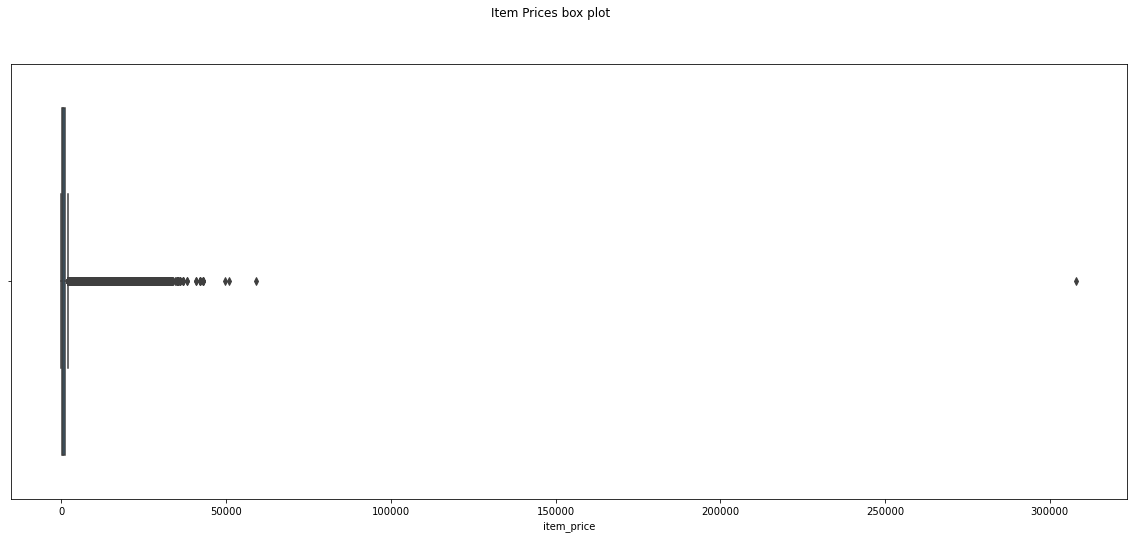

In [27]:
fig = plt.figure(figsize=(20, 8))
ax = plt.axes()
fig.suptitle("Item Prices box plot")
sns.boxplot(x=normData.item_price, ax=ax)
plt.show()

It seems that there is a extreme outlier especially hee sales_price higher than 300000. We will look further into the outliers. 

In [28]:
normData[normData.item_price >= 300000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
1163158,2013-12-13,11,12,6066,307980.0,1.0,Интернет-магазин ЧС,Radmin 3 - 522 лиц.,75,Программы - Для дома и офиса


Note: the result above will be empty if the remove parameter is set. 

It appears that there is only 1 item for item_price >= 300000. Let's check how many 6066 item_id in the data set. 

In [29]:
print("Number of record with item_id 6066: {}".format(len(normData[normData.item_id == 6066])))

Number of record with item_id 6066: 1


Only 1 record therefore we can definately delete the outlier. 

In [30]:
normData = normData[normData.item_price < 300000]

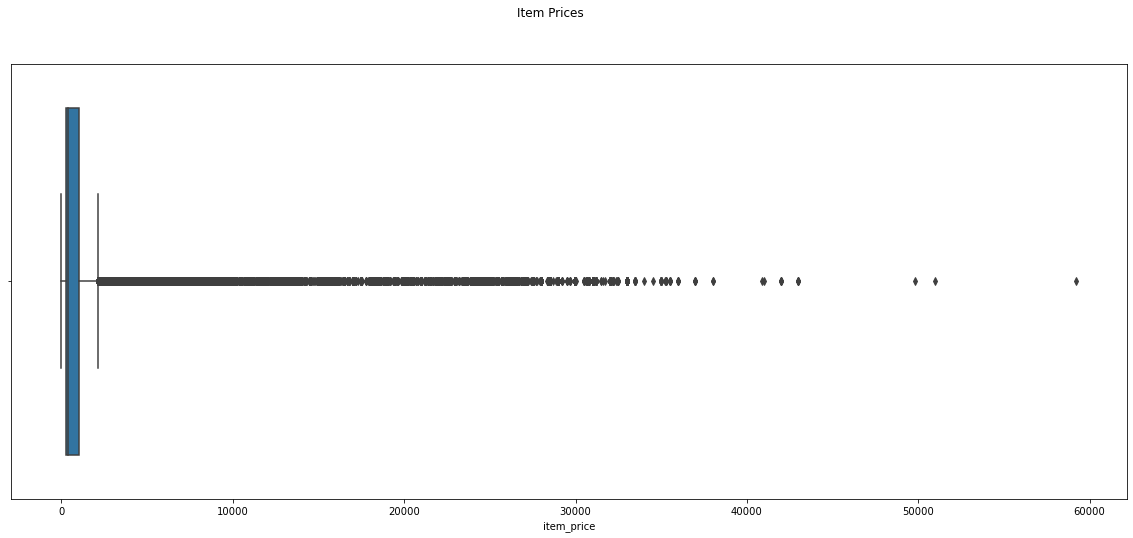

In [31]:
fig = plt.figure(figsize=(20, 8))
ax = plt.axes()
fig.suptitle("Item Prices")
sns.boxplot(x=normData.item_price, ax=ax)
plt.show()

**1.2.4 Check item count** <a class="anchor" id="section_1_2_4"></a>

In the section below, we will look into item count

In [32]:
normData.item_cnt_day.describe()

count    2.935848e+06
mean     1.242641e+00
std      2.618835e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64

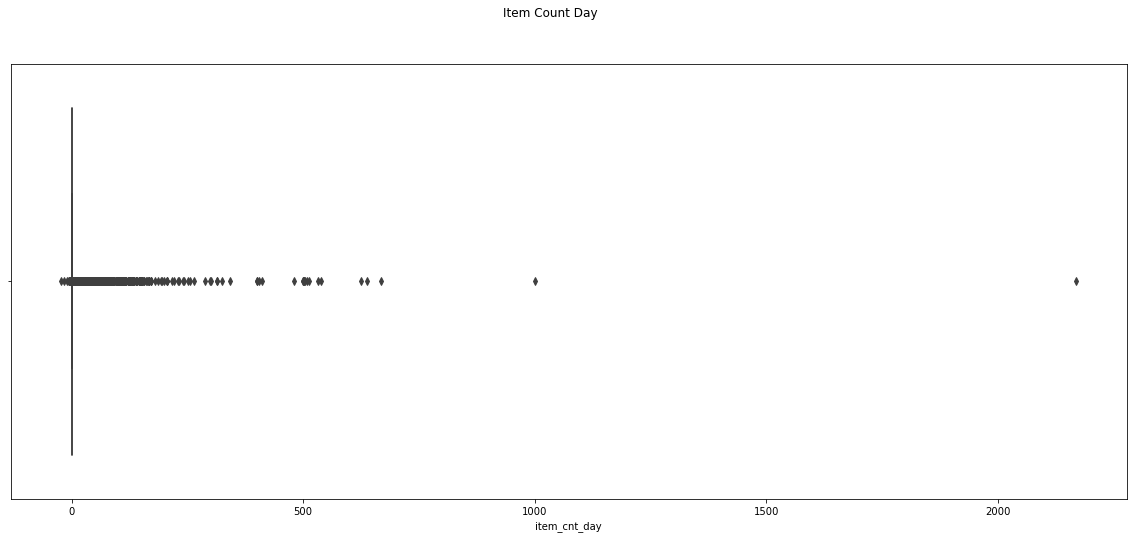

In [33]:
fig = plt.figure(figsize=(20, 8))
ax = plt.axes()
fig.suptitle("Item Count Day")
sns.boxplot(x=normData.item_cnt_day, ax=ax)
plt.show()

Let's check the outlier 

In [34]:
checkItemCnt = normData[normData.item_cnt_day >= 500]

checkItemCnt

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
1573253,2014-04-22,15,27,8057,1200.000000,502.0,"Москва ТЦ ""МЕГА Белая Дача II""",iTunes 1500 руб.,32,"Карты оплаты (Кино, Музыка, Игры)"
1708207,2014-06-28,17,25,20949,5.000000,501.0,"Москва ТРК ""Атриум""",Фирменный пакет майка 1С Интерес белый (34*42)...,71,"Подарки - Сумки, Альбомы, Коврики д/мыши"
2048518,2014-10-02,21,12,9242,1500.000000,512.0,Интернет-магазин ЧС,"Билет ""ИгроМир 2014"" (на один день (отдельно -...",8,Билеты (Цифра)
2067669,2014-10-09,21,55,19437,899.000000,508.0,Цифровой склад 1С-Онлайн,"Средиземье: Тени Мордора [PC, Цифровая версия]",31,Игры PC - Цифра
2257299,2014-12-19,23,12,20949,4.000000,500.0,Интернет-магазин ЧС,Фирменный пакет майка 1С Интерес белый (34*42)...,71,"Подарки - Сумки, Альбомы, Коврики д/мыши"
2326930,2015-01-15,24,12,20949,4.000000,1000.0,Интернет-магазин ЧС,Фирменный пакет майка 1С Интерес белый (34*42)...,71,"Подарки - Сумки, Альбомы, Коврики д/мыши"
2608040,2015-04-14,27,12,3731,1904.548077,624.0,Интернет-магазин ЧС,"Grand Theft Auto V [PC, русские субтитры]",30,Игры PC - Стандартные издания
2626181,2015-05-19,28,12,11373,155.192950,539.0,Интернет-магазин ЧС,Доставка до пункта выдачи (Boxberry),9,Доставка товара
2851073,2015-09-29,32,55,9249,1500.000000,533.0,Цифровой склад 1С-Онлайн,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) У...",8,Билеты (Цифра)
2851091,2015-09-30,32,55,9249,1702.825746,637.0,Цифровой склад 1С-Онлайн,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) У...",8,Билеты (Цифра)


In the section below, we would like to check whether the outliers are included in the item list of the predicted/submission files.

In [35]:
for idx in checkItemCnt.index:
    id = checkItemCnt.loc[idx, "item_id"]
    checkItemCnt.loc[idx, "Required"] = id in testUniID

checkItemCnt.sort_values(by= "item_id")
    
#checkItemCnt[checkItemCnt.Required == True]

C:\Users\KANGHEA\Anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\KANGHEA\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name,Required
2608040,2015-04-14,27,12,3731,1904.548077,624.0,Интернет-магазин ЧС,"Grand Theft Auto V [PC, русские субтитры]",30,Игры PC - Стандартные издания,True
1573253,2014-04-22,15,27,8057,1200.000000,502.0,"Москва ТЦ ""МЕГА Белая Дача II""",iTunes 1500 руб.,32,"Карты оплаты (Кино, Музыка, Игры)",False
2048518,2014-10-02,21,12,9242,1500.000000,512.0,Интернет-магазин ЧС,"Билет ""ИгроМир 2014"" (на один день (отдельно -...",8,Билеты (Цифра),False
2864235,2015-09-30,32,12,9248,1692.526158,669.0,Интернет-магазин ЧС,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) [...",80,Служебные - Билеты,False
2864260,2015-09-29,32,12,9248,1500.000000,504.0,Интернет-магазин ЧС,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) [...",80,Служебные - Билеты,False
2851073,2015-09-29,32,55,9249,1500.000000,533.0,Цифровой склад 1С-Онлайн,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) У...",8,Билеты (Цифра),False
2851091,2015-09-30,32,55,9249,1702.825746,637.0,Цифровой склад 1С-Онлайн,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) У...",8,Билеты (Цифра),False
2626181,2015-05-19,28,12,11373,155.192950,539.0,Интернет-магазин ЧС,Доставка до пункта выдачи (Boxberry),9,Доставка товара,True
2909818,2015-10-28,33,12,11373,0.908714,2169.0,Интернет-магазин ЧС,Доставка до пункта выдачи (Boxberry),9,Доставка товара,True
2067669,2014-10-09,21,55,19437,899.000000,508.0,Цифровой склад 1С-Онлайн,"Средиземье: Тени Мордора [PC, Цифровая версия]",31,Игры PC - Цифра,False


It appears that some of the item_id do have high item_cnt_day number. 

Let's look further into 3731 and 8057 as they only have 1 rows

In [36]:
checkItemCnt = normData[normData.item_id == 3731]

checkItemCnt.sort_values(by = 'item_cnt_day')

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
2625897,2015-05-28,28,12,3731,1999.000000,-1.0,Интернет-магазин ЧС,"Grand Theft Auto V [PC, русские субтитры]",30,Игры PC - Стандартные издания
2904514,2015-10-15,33,53,3731,2199.000000,-1.0,"Уфа ТЦ ""Семья"" 2","Grand Theft Auto V [PC, русские субтитры]",30,Игры PC - Стандартные издания
2813516,2015-08-13,31,3,3731,1999.000000,-1.0,"Балашиха ТРК ""Октябрь-Киномир""","Grand Theft Auto V [PC, русские субтитры]",30,Игры PC - Стандартные издания
2703993,2015-06-18,29,4,3731,1999.000000,-1.0,"Волжский ТЦ ""Волга Молл""","Grand Theft Auto V [PC, русские субтитры]",30,Игры PC - Стандартные издания
2728024,2015-07-04,30,16,3731,1999.000000,-1.0,"Коломна ТЦ ""Рио""","Grand Theft Auto V [PC, русские субтитры]",30,Игры PC - Стандартные издания
...,...,...,...,...,...,...,...,...,...,...
2605020,2015-04-14,27,18,3731,1930.034483,145.0,"Красноярск ТЦ ""Июнь""","Grand Theft Auto V [PC, русские субтитры]",30,Игры PC - Стандартные издания
2555809,2015-04-14,27,31,3731,1946.953216,171.0,"Москва ТЦ ""Семеновский""","Grand Theft Auto V [PC, русские субтитры]",30,Игры PC - Стандартные издания
2567454,2015-04-14,27,25,3731,1941.995169,207.0,"Москва ТРК ""Атриум""","Grand Theft Auto V [PC, русские субтитры]",30,Игры PC - Стандартные издания
2597018,2015-04-14,27,42,3731,1918.732441,299.0,"СПб ТК ""Невский Центр""","Grand Theft Auto V [PC, русские субтитры]",30,Игры PC - Стандартные издания


In [37]:
checkItemCnt = normData[normData.item_id == 8057]

checkItemCnt.sort_values(by = 'item_cnt_day')

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
807027,2013-08-24,7,28,8057,1500.0,1.0,"Москва ТЦ ""МЕГА Теплый Стан"" II",iTunes 1500 руб.,32,"Карты оплаты (Кино, Музыка, Игры)"
1596496,2014-04-28,15,42,8057,1500.0,1.0,"СПб ТК ""Невский Центр""",iTunes 1500 руб.,32,"Карты оплаты (Кино, Музыка, Игры)"
1596497,2014-04-04,15,42,8057,1500.0,1.0,"СПб ТК ""Невский Центр""",iTunes 1500 руб.,32,"Карты оплаты (Кино, Музыка, Игры)"
1599851,2014-04-25,15,44,8057,1500.0,1.0,"Самара ТЦ ""Мелодия""",iTunes 1500 руб.,32,"Карты оплаты (Кино, Музыка, Игры)"
1631422,2014-05-24,16,27,8057,1500.0,1.0,"Москва ТЦ ""МЕГА Белая Дача II""",iTunes 1500 руб.,32,"Карты оплаты (Кино, Музыка, Игры)"
...,...,...,...,...,...,...,...,...,...,...
2043157,2014-10-01,21,27,8057,1500.0,11.0,"Москва ТЦ ""МЕГА Белая Дача II""",iTunes 1500 руб.,32,"Карты оплаты (Кино, Музыка, Игры)"
1571406,2014-04-23,15,21,8057,1200.0,100.0,"Москва МТРЦ ""Афи Молл""",iTunes 1500 руб.,32,"Карты оплаты (Кино, Музыка, Игры)"
1618930,2014-04-23,15,29,8057,1200.0,240.0,"Москва ТЦ ""Новый век"" (Новокосино)",iTunes 1500 руб.,32,"Карты оплаты (Кино, Музыка, Игры)"
1573252,2014-04-23,15,27,8057,1200.0,401.0,"Москва ТЦ ""МЕГА Белая Дача II""",iTunes 1500 руб.,32,"Карты оплаты (Кино, Музыка, Игры)"


Based on the section above, it appears item_cnt_day for 3731 and 8057 outliers is not a one off number. Potentially they have good sales during some days. Therefore we will keep the outliers


In [38]:
print("Number of Distinct Item: " + str(len(pd.unique(normData['item_id']))))
print("Number of Distinct Item Catgory: " + str(len(pd.unique(normData['item_category_id']))))
print("Number of Distinct Shop ID: " + str(len(pd.unique(normData['shop_id']))))

Number of Distinct Item: 21806
Number of Distinct Item Catgory: 84
Number of Distinct Shop ID: 60


### 1.3 Exploratory Data Analysis <a class="anchor" id="section_1_3"></a>

First we will need to add date related new columns for better analysis 

In [39]:
normData['date_month'] = normData['date'].dt.month
normData['date_year'] = normData['date'].dt.year
#Calculate total normData
normData['total_sales'] =  normData['item_price'] * normData['item_cnt_day']

Prepare the sales year split by year for reusability

**Run code below to get the cleaned data as CSV**

In [40]:
#Save data as CSV file for analysis

normData.to_csv('predictFutureSalesClean.csv') 

In [41]:
sales2013 = normData[normData['date_year'] == 2013]
sales2014 = normData[normData['date_year'] == 2014]
sales2015 = normData[normData['date_year'] == 2015]

The code above is to slice the data set to import data processing.

**1.3.1 General Sales Trend** <a class="anchor" id="section_1_3_1"></a>

In [42]:
# Find aggregate sales by day
salesMonYea2013 = sales2013.groupby(['date_month','date_year'])[['total_sales']].agg('sum').reset_index()
salesMonYea2014 = sales2014.groupby(['date_month','date_year'])[['total_sales']].agg('sum').reset_index()
salesMonYea2015 = sales2015.groupby(['date_month','date_year'])[['total_sales']].agg('sum').reset_index()

totalSales = pd.concat([salesMonYea2013,salesMonYea2014,salesMonYea2015])

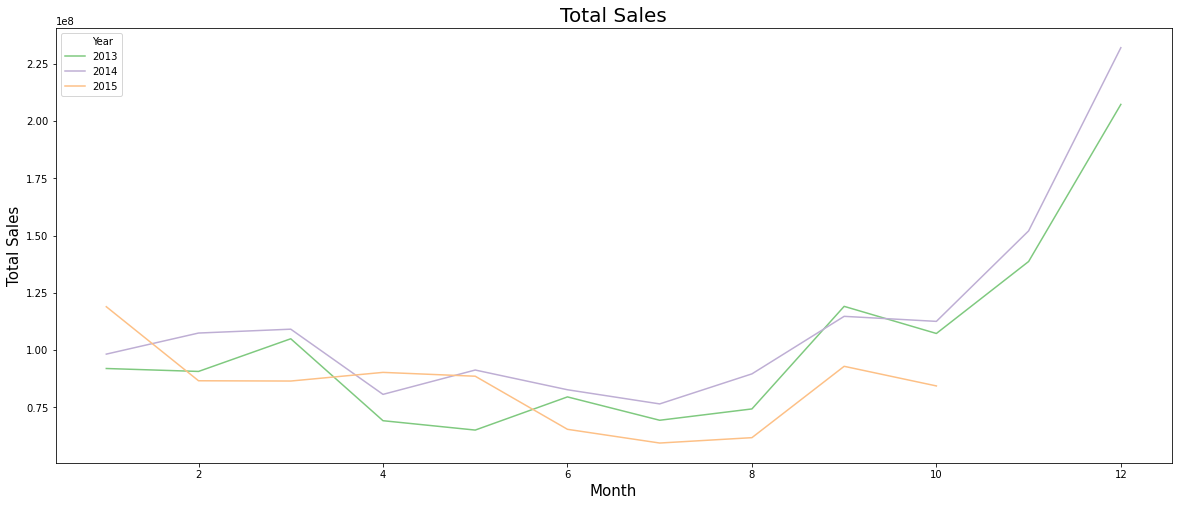

In [43]:
fig0,ax0=plt.subplots(figsize=(20,8));
sns.lineplot(x='date_month', y = 'total_sales', data = totalSales,
           hue='date_year', palette = 'Accent')

plt.title("Total Sales", fontsize = 20)
plt.xlabel("Month", fontsize = 15)
plt.ylabel("Total Sales", fontsize = 15)
legend = ax0.legend()
legend.texts[0].set_text("Year")
plt.show()

Let's look at the heatmap for sales trend

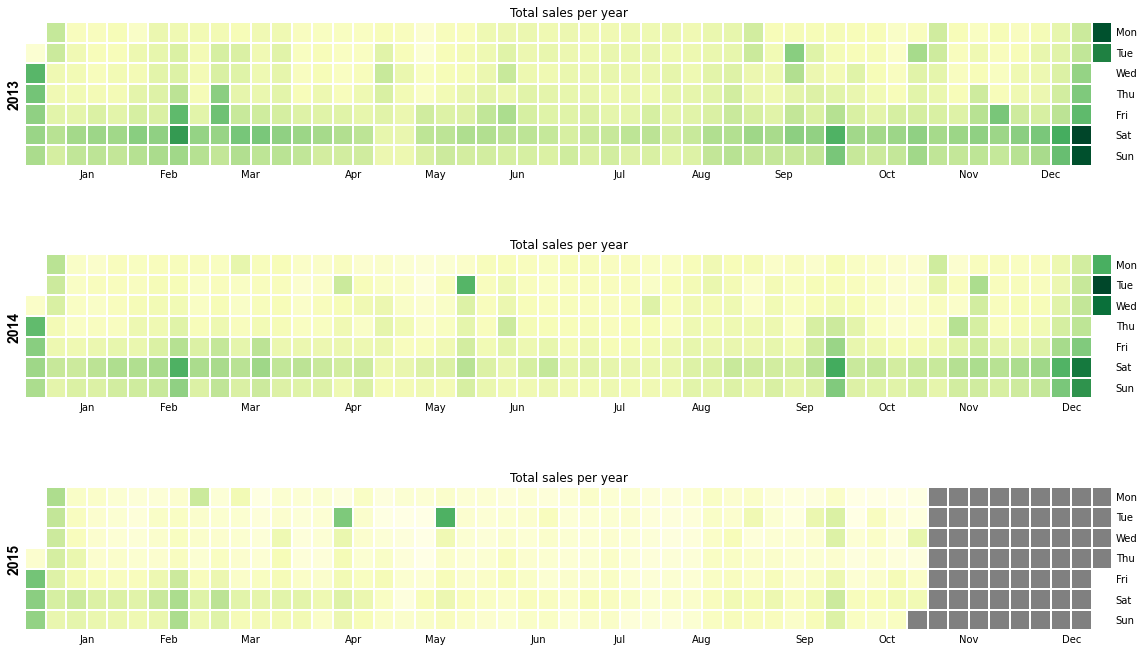

In [44]:
calHeatMap = normData[["date", "item_cnt_day"]]

calHeatMap.set_index("date", inplace = True)

calHeatMap = calHeatMap.resample("D")["item_cnt_day"].sum()

calmap.calendarplot(calHeatMap, # pass the series
                    fig_kws = {'figsize': (16,10)}, 
                    cmap='YlGn',
                    fillcolor='grey',
                    yearlabel_kws = {'color':'black', 'fontsize':14}, 
                    subplot_kws = {'title':'Total sales per year'}
                   );

In [45]:
all_data = normData
all_data['date'] = pd.to_datetime(all_data.date, format='%Y.%m.%d')
all_data['date_week'] = all_data.date.dt.week
all_data['dayofweek_name'] = all_data.date.dt.day_name()
all_data['dayofweek_no'] = all_data.date.dt.dayofweek 
all_data['wrk_week'] = np.where(all_data['date_year']==2013, all_data['date_week'], np.where(all_data['date_year']==2014, all_data['date_week']+52, all_data['date_week']+104))

In [46]:
sales.dtypes

date              datetime64[ns]
date_block_num             int64
shop_id                    int64
item_id                    int64
item_price               float64
item_cnt_day             float64
dtype: object

In [47]:
#sort the values on date, shop_id and item_id
all_data = all_data.sort_values(by=['date', 'shop_id', 'item_id'])

Text(0, 0.5, 'Total Sales')

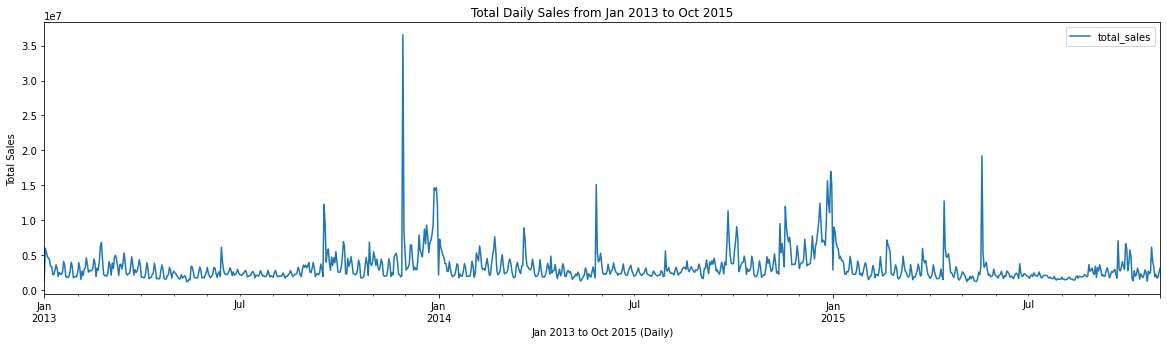

In [48]:
#plot daily line graph from jan 2013 to oct 2015
all_data_by_date = all_data[['date', 'total_sales']]

aggregations = {'total_sales':'sum'}
all_data_by_date = all_data_by_date.groupby(['date'], as_index=False).agg(aggregations)
pd.set_option('display.float_format', '{:20,.2f}'.format)

ax = all_data_by_date.plot(x='date', y='total_sales', kind='line', figsize=(20,5))
ax.set_title('Total Daily Sales from Jan 2013 to Oct 2015')
ax.set_xlabel("Jan 2013 to Oct 2015 (Daily)")
ax.set_ylabel("Total Sales")

The above shows the sales trend from 2013 until 2015. We could observe that there is a daily spike trend for end of year.

Text(0, 0.5, 'Total Sales')

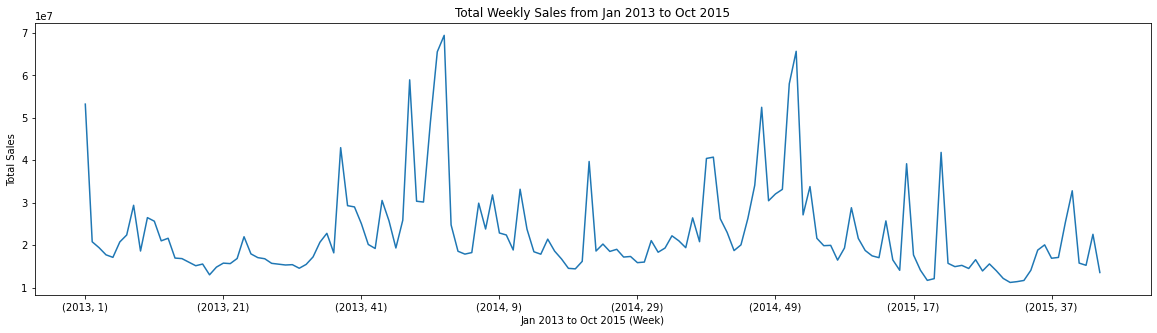

In [49]:
#plot weekly line graph from jan 2013 to oct 2015
all_data_by_week = all_data[['date', 'total_sales', 'date_week', 'date_year']]
#all_data_working

aggregations = {'total_sales':'sum'}
all_data_by_week = all_data_by_week.groupby(['date_year', 'date_week']).agg(aggregations)
pd.set_option('display.float_format', '{:20,.2f}'.format)
#all_data_by_week
ax = all_data_by_week['total_sales'].plot(figsize=(20,5))
ax.set_title('Total Weekly Sales from Jan 2013 to Oct 2015')
ax.set_xlabel("Jan 2013 to Oct 2015 (Week)")
ax.set_ylabel("Total Sales")

The above is the sales trend by week. 

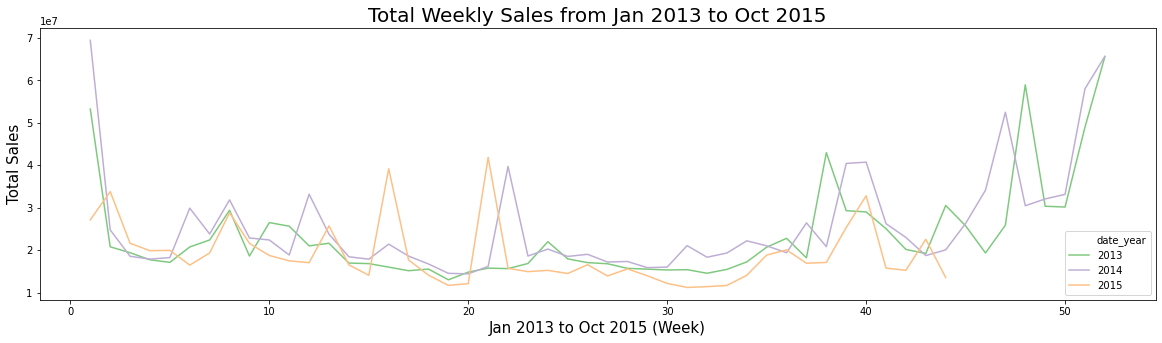

In [50]:
#plot weekly graph by year for better comparison
all_data_by_week = all_data.groupby(['date_week', 'date_year'])[['total_sales']].agg('sum').reset_index()
#all_data_agg


plt.rcParams['figure.figsize']=(20, 5)
sns.lineplot(x='date_week', y='total_sales', hue='date_year', data = all_data_by_week, palette='Accent')
plt.title("Total Weekly Sales from Jan 2013 to Oct 2015", fontsize = 20)
plt.xlabel("Jan 2013 to Oct 2015 (Week)", fontsize = 15)
plt.ylabel("Total Sales", fontsize = 15)
#plt.figure(figsize=(100, 6))
plt.show()

Text(0, 0.5, 'Total Sales')

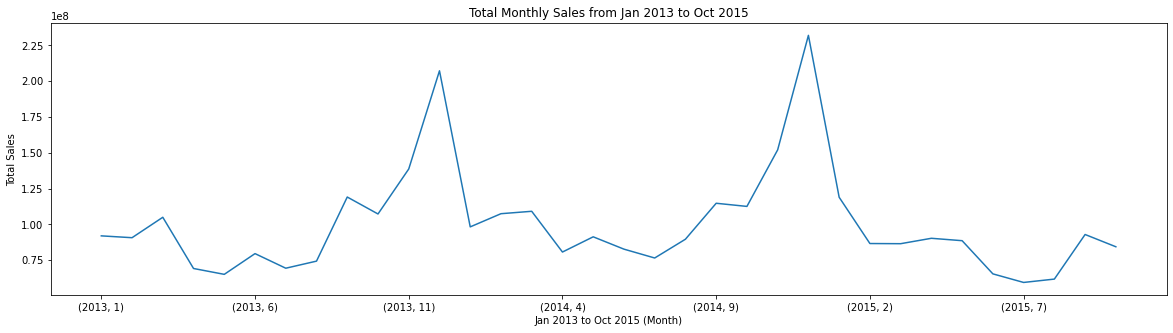

In [51]:
#plot monthly line graph from jan 2013 to oct 2015
all_data_by_month = all_data[['date', 'total_sales', 'date_month', 'date_year']]
#all_data_working

aggregations = {'total_sales':'sum'}
all_data_by_month = all_data_by_month.groupby(['date_year', 'date_month']).agg(aggregations)
pd.set_option('display.float_format', '{:20,.2f}'.format)
#all_data_by_week
ax = all_data_by_month['total_sales'].plot(figsize=(20,5))
ax.set_title('Total Monthly Sales from Jan 2013 to Oct 2015')
ax.set_xlabel("Jan 2013 to Oct 2015 (Month)")
ax.set_ylabel("Total Sales")

The above is the monthly sales. 

Let's check item count trend as well

In [52]:
# Find aggregate sales by day
itemCntYea2013 = sales2013.groupby(['date_month','date_year'])[['item_cnt_day']].agg('sum').reset_index()
itemCntYea2014 = sales2014.groupby(['date_month','date_year'])[['item_cnt_day']].agg('sum').reset_index()
itemCntYea2015 = sales2015.groupby(['date_month','date_year'])[['item_cnt_day']].agg('sum').reset_index()

itemCntYea = pd.concat([itemCntYea2013,itemCntYea2014,itemCntYea2015])

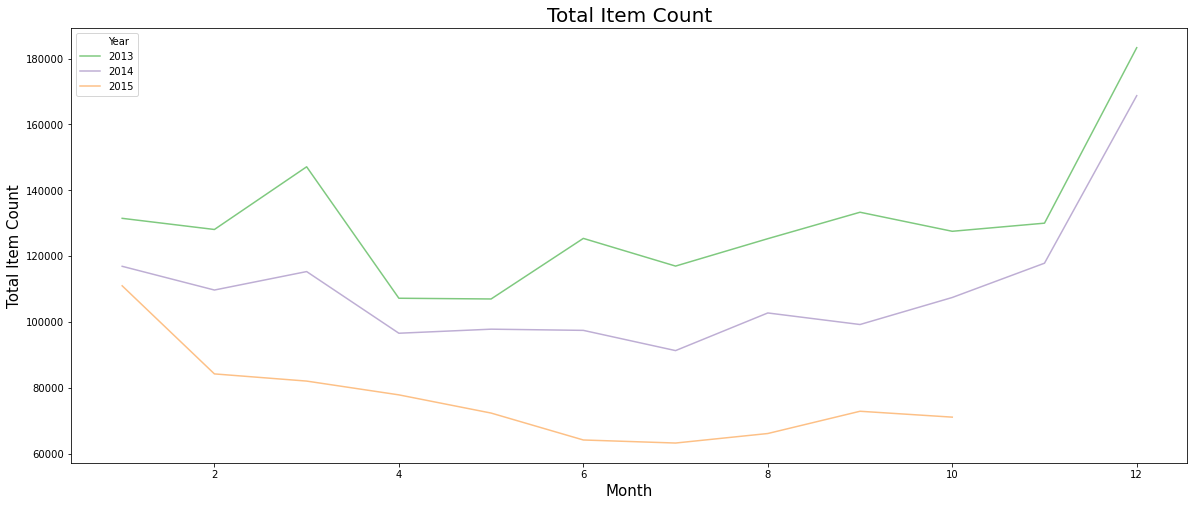

In [53]:
fig0,ax0=plt.subplots(figsize=(20,8));
sns.lineplot(x='date_month', y = 'item_cnt_day', data = itemCntYea,
           hue='date_year', palette = 'Accent')

plt.title("Total Item Count", fontsize = 20)
plt.xlabel("Month", fontsize = 15)
plt.ylabel("Total Item Count", fontsize = 15)
legend = ax0.legend()
legend.texts[0].set_text("Year")
plt.show()

**1.3.2 Items** <a class="anchor" id="section_1_3_2"></a>

In the section below, we will look further into the items data. 

In [54]:

item_sales = normData.groupby(['item_id'])[['total_sales']].agg('sum').reset_index()

item_sales

,item_id,total_sales
0,0,58.00
1,1,"26,940.00"
2,2,116.00
3,3,158.00
4,4,58.00
...,...,...
21801,22165,118.00
21802,22166,"52,200.00"
21803,22167,"393,108.75"
21804,22168,"4,793.50"


Let's explore the graph for Top 10 Total Sales by Item

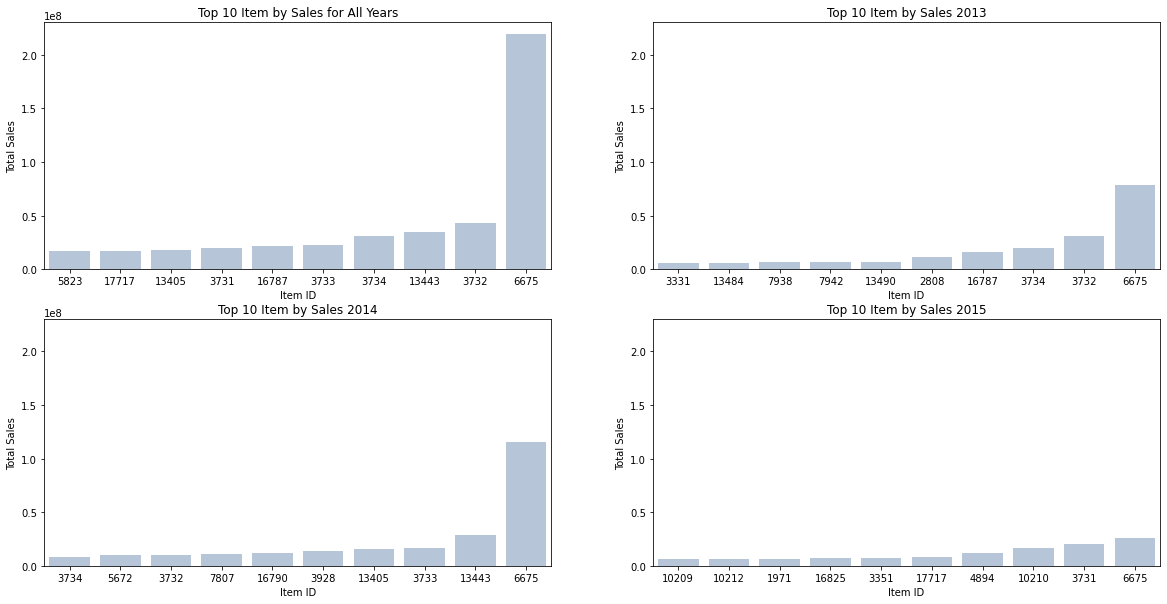

In [55]:
def buildItemSalesGraph(df,ax0,year):
    
    item_sales = df.groupby(['item_id'])[['total_sales']].agg('sum').reset_index()
    
    item_sales = item_sales.sort_values(by=['total_sales'], ascending =False)

    item_sales = item_sales.head(n = 10)
    
    axTotal= sns.barplot(ax=ax0, x = item_sales.item_id, 
                y = item_sales.total_sales,
               order= item_sales.sort_values('total_sales').item_id,
                color = 'lightsteelblue')
   
    if year == '':
        axTotal.title.set_text('Top 10 Item by Sales for All Years')
    else: 
        title = 'Top 10 Item by Sales ' + str(year)
        axTotal.title.set_text(title)
    
    axTotal.set_xlabel('Item ID')
    axTotal.set_ylabel('Total Sales')
    axTotal.yaxis.set_tick_params(labelbottom=True)
    
# Checking best item selling by sales - Top 10
# Prepare subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 10), sharey=True)

buildItemSalesGraph(normData,axes[0,0],'')
buildItemSalesGraph(sales2013,axes[0,1],2013)
buildItemSalesGraph(sales2014,axes[1,0],2014)
buildItemSalesGraph(sales2015,axes[1,1],2015)

Let's explore the graph for Top 10 Total Sales by Item

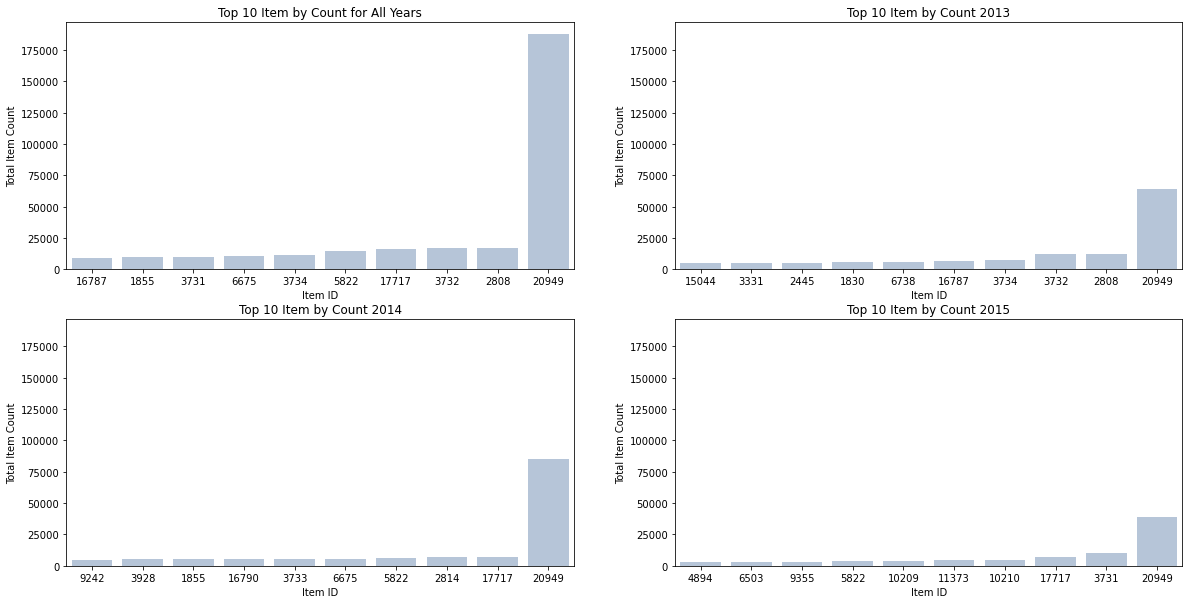

In [56]:
def buildItemCntGraph(df,ax0,year):

    sales_item_cnt = df.groupby(['item_id'])[['item_cnt_day']].agg('sum').reset_index()

    sales_item_cnt = sales_item_cnt.sort_values(by=['item_cnt_day'], ascending =False)

    sales_item_cnt = sales_item_cnt.head(n = 10)

    ax= sns.barplot(ax=ax0, x = sales_item_cnt.item_id, 
                y = sales_item_cnt.item_cnt_day,
               order=sales_item_cnt.sort_values('item_cnt_day').item_id,
                   color = 'lightsteelblue')
    
    if year == '':
        ax.title.set_text('Top 10 Item by Count for All Years')
    else: 
        title = 'Top 10 Item by Count ' + str(year)
        ax.title.set_text(title)
    
    ax.set_xlabel('Item ID')
    ax.set_ylabel('Total Item Count')
    ax.yaxis.set_tick_params(labelbottom=True)
    
# Checking best item selling by sales - Top 10
# Prepare subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 10), sharey=True)

buildItemCntGraph(normData,axes[0,0],'')
buildItemCntGraph(sales2013,axes[0,1],2013)
buildItemCntGraph(sales2014,axes[1,0],2014)
buildItemCntGraph(sales2015,axes[1,1],2015)

**1.3.3 Shop** <a class="anchor" id="section_1_3_3"></a>

In the section below, we will look further into the shop data.

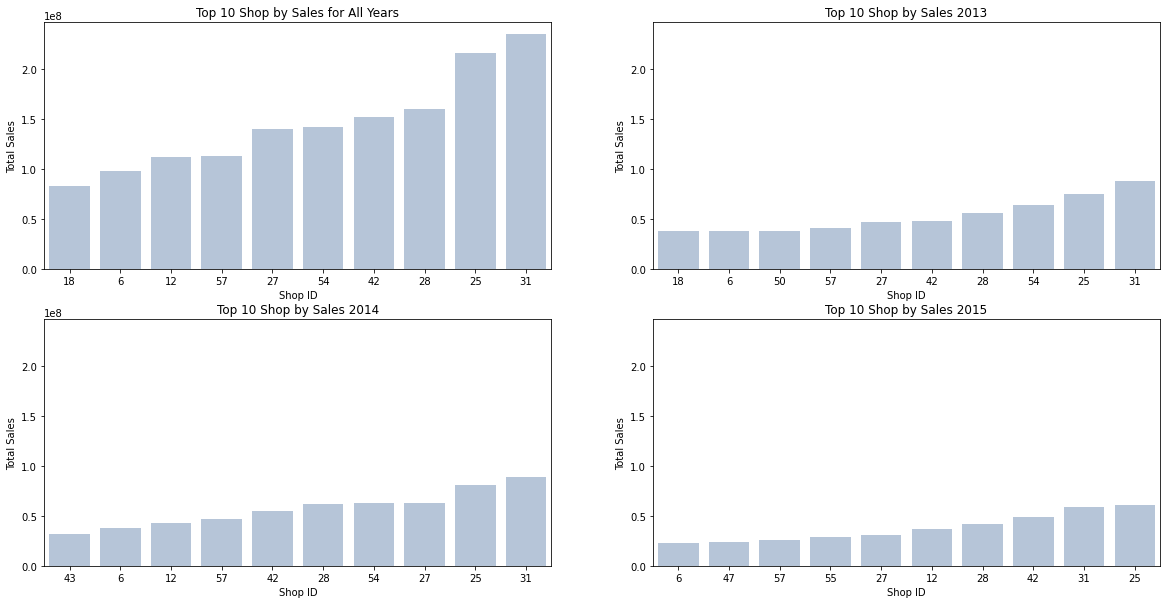

In [57]:
# Checking Shop with top 10 Sales
# Prepare subplots
def buildShopSalesGraph(df,ax0,year):

    sales_shop = df.groupby(['shop_id'])[['total_sales']].agg('sum').reset_index()

    sales_shop = sales_shop.sort_values(by=['total_sales'], ascending =False)

    sales_shop = sales_shop.head(n = 10)

    ax= sns.barplot(ax=ax0, x = sales_shop.shop_id, 
                y = sales_shop.total_sales,
               order=sales_shop.sort_values('total_sales').shop_id,
                   color = 'lightsteelblue')
    
    if year == '':
        ax.title.set_text('Top 10 Shop by Sales for All Years')
    else: 
        title = 'Top 10 Shop by Sales ' + str(year)
        ax.title.set_text(title)
    
    ax.set_xlabel('Shop ID')
    ax.set_ylabel('Total Sales')
    ax.yaxis.set_tick_params(labelbottom=True)

# Checking best item selling by sales - Top 10
# Prepare subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 10), sharey=True)

buildShopSalesGraph(normData,axes[0,0],'')
buildShopSalesGraph(sales2013,axes[0,1],2013)
buildShopSalesGraph(sales2014,axes[1,0],2014)
buildShopSalesGraph(sales2015,axes[1,1],2015)

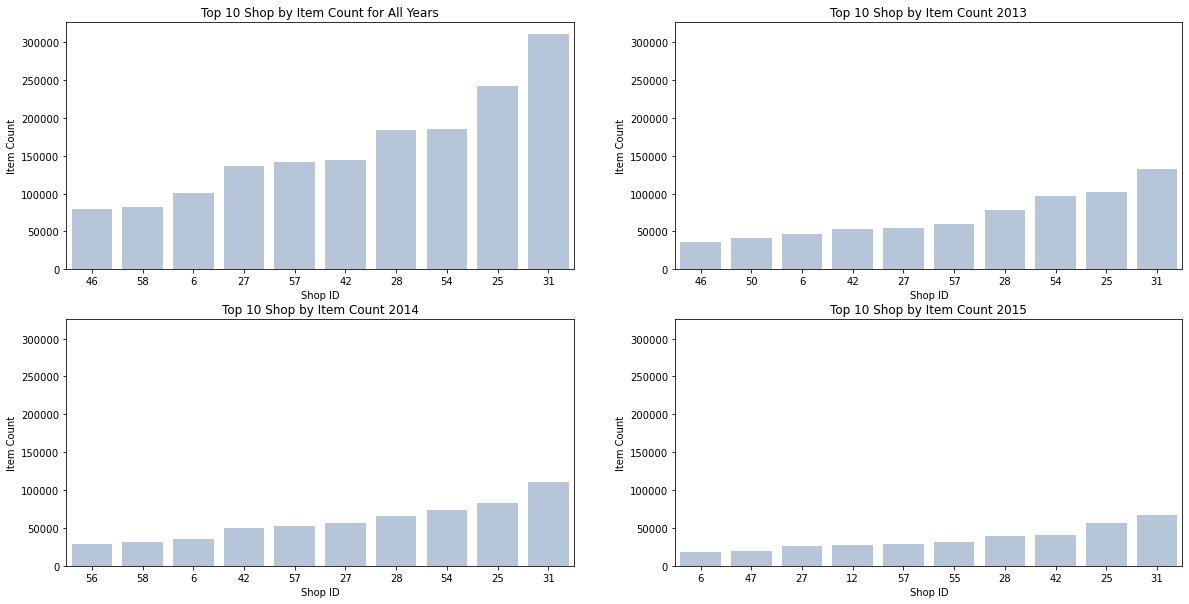

In [58]:
# Checking Top 10 shop with Item count
# Prepare subplots
def buildShopCntGraph(df,ax0,year):

    sales_shop = df.groupby(['shop_id'])[['item_cnt_day']].agg('sum').reset_index()

    sales_shop = sales_shop.sort_values(by=['item_cnt_day'], ascending =False)

    sales_shop = sales_shop.head(n = 10)

    ax= sns.barplot(ax=ax0, x = sales_shop.shop_id, 
                y = sales_shop.item_cnt_day,
               order=sales_shop.sort_values('item_cnt_day').shop_id,
                   color = 'lightsteelblue')
    
    if year == '':
        ax.title.set_text('Top 10 Shop by Item Count for All Years')
    else: 
        title = 'Top 10 Shop by Item Count ' + str(year)
        ax.title.set_text(title)
    
    ax.set_xlabel('Shop ID')
    ax.set_ylabel('Item Count')
    ax.yaxis.set_tick_params(labelbottom=True)

# Checking best item selling by sales - Top 10
# Prepare subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 10),sharey=True)

buildShopCntGraph(normData,axes[0,0],'')
buildShopCntGraph(sales2013,axes[0,1],2013)
buildShopCntGraph(sales2014,axes[1,0],2014)
buildShopCntGraph(sales2015,axes[1,1],2015)



**1.3.4 Categories** <a class="anchor" id="section_1_3_4"></a>

In the section below, we will look further into the categories data.

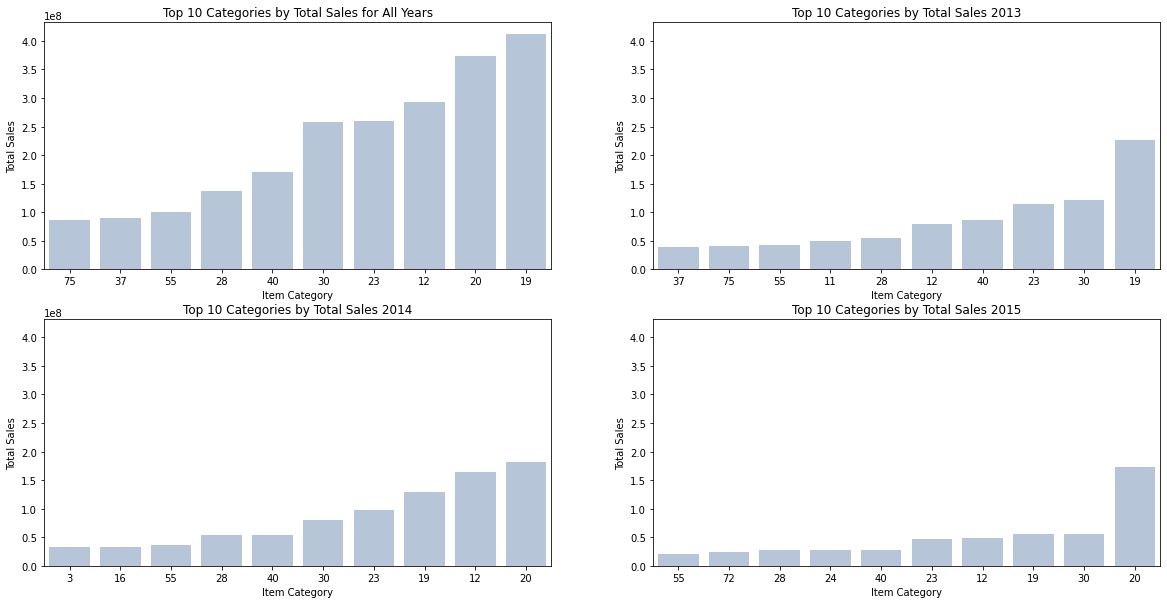

In [59]:
# Checking Top 10 shop with Item count
# Prepare subplots
def buildCatSalesGraph(df,ax0,year):

    sales_cat = df.groupby(['item_category_id'])[['total_sales']].agg('sum').reset_index()

    sales_cat = sales_cat.sort_values(by=['total_sales'], ascending =False)

    sales_cat = sales_cat.head(n = 10)

    ax= sns.barplot(ax=ax0, x = sales_cat.item_category_id, 
                y = sales_cat.total_sales,
               order=sales_cat.sort_values('total_sales').item_category_id,
                   color = 'lightsteelblue')
    
    if year == '':
        ax.title.set_text('Top 10 Categories by Total Sales for All Years')
    else: 
        title = 'Top 10 Categories by Total Sales ' + str(year)
        ax.title.set_text(title)
    
    ax.set_xlabel('Item Category')
    ax.set_ylabel('Total Sales')
    ax.yaxis.set_tick_params(labelbottom=True)

# Checking best item selling by sales - Top 10
# Prepare subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 10),sharey=True)

buildCatSalesGraph(normData,axes[0,0],'')
buildCatSalesGraph(sales2013,axes[0,1],2013)
buildCatSalesGraph(sales2014,axes[1,0],2014)
buildCatSalesGraph(sales2015,axes[1,1],2015)

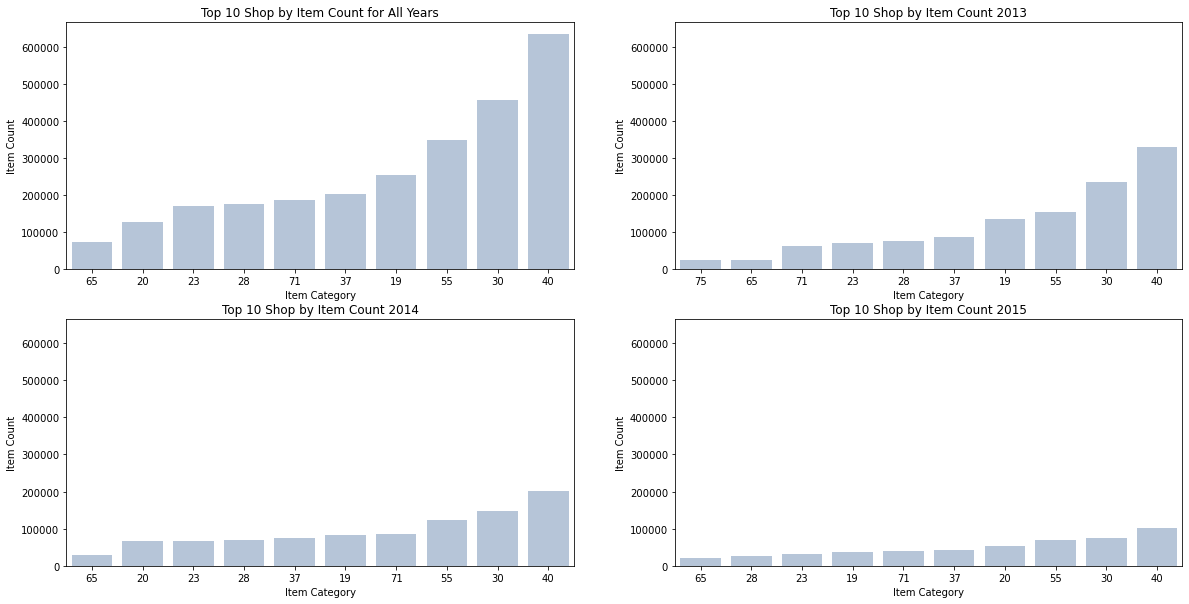

In [60]:
# Checking Top 10 shop with Item count
# Prepare subplots
def buildCatCntGraph(df,ax0,year):

    sales_cat = df.groupby(['item_category_id'])[['item_cnt_day']].agg('sum').reset_index()

    sales_cat = sales_cat.sort_values(by=['item_cnt_day'], ascending =False)

    sales_cat = sales_cat.head(n = 10)

    ax= sns.barplot(ax=ax0, x = sales_cat.item_category_id, 
                y = sales_cat.item_cnt_day,
               order=sales_cat.sort_values('item_cnt_day').item_category_id,
                   color = 'lightsteelblue')
    
    if year == '':
        ax.title.set_text('Top 10 Shop by Item Count for All Years')
    else: 
        title = 'Top 10 Shop by Item Count ' + str(year)
        ax.title.set_text(title)
    
    ax.set_xlabel('Item Category')
    ax.set_ylabel('Item Count')
    ax.yaxis.set_tick_params(labelbottom=True)

# Checking best item selling by sales - Top 10
# Prepare subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 10),sharey=True)

buildCatCntGraph(normData,axes[0,0],'')
buildCatCntGraph(sales2013,axes[0,1],2013)
buildCatCntGraph(sales2014,axes[1,0],2014)
buildCatCntGraph(sales2015,axes[1,1],2015)



In [2]:
#reading data from file
train = pd.read_csv(r'C:/Testing/DA/predictFutureSalesClean.csv')
test = pd.read_csv('C:/Testing/DA/test.csv')
sample_submission = pd.read_csv('C:/Testing/DA/sample_submission.csv')
items = pd.read_csv('C:/Testing/DA/items.csv')
item_cats = pd.read_csv('C:/Testing/DA/item_categories.csv')
shops = pd.read_csv('C:/Testing/DA/shops.csv')

In [3]:
#checking the data types of train
train.dtypes

Unnamed: 0              int64
date                   object
date_block_num          int64
shop_id                 int64
item_id                 int64
item_price            float64
item_cnt_day          float64
shop_name              object
item_name              object
item_category_id        int64
Required                 bool
item_category_name     object
date_month              int64
date_year               int64
total_sales           float64
dtype: object

## 2. Feature Engineering  <a class="anchor" id="section_2"></a>

### 2.1 Lag Features <a class="anchor" id="section_2_1"></a>

A lag value of 7 is being chosen to correlate of weekly trend

In [49]:
#lag feature - to be used as the bases for machine learning

all_data_by_day = all_data
aggregations = {'total_sales':'sum'}
all_data_by_day = all_data_by_day.groupby(['date'], as_index=False).agg(aggregations)
all_data_by_day['lag_1'] = all_data_by_day['total_sales'].shift(1)
all_data_by_day['lag_2'] = all_data_by_day['total_sales'].shift(2)
all_data_by_day['lag_3'] = all_data_by_day['total_sales'].shift(3)
all_data_by_day['lag_4'] = all_data_by_day['total_sales'].shift(4)
all_data_by_day['lag_5'] = all_data_by_day['total_sales'].shift(5)
all_data_by_day['lag_6'] = all_data_by_day['total_sales'].shift(6)
all_data_by_day['lag_7'] = all_data_by_day['total_sales'].shift(7)
all_data_by_day

,date,total_sales,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
0,2013-01-01,"286,396",nan,nan,nan,nan,nan,nan,nan
1,2013-01-02,"1,258,655","286,396",nan,nan,nan,nan,nan,nan
2,2013-01-03,"1,131,019","1,258,655","286,396",nan,nan,nan,nan,nan
3,2013-01-04,"965,669","1,131,019","1,258,655","286,396",nan,nan,nan,nan
4,2013-01-05,"955,023","965,669","1,131,019","1,258,655","286,396",nan,nan,nan
...,...,...,...,...,...,...,...,...,...
1029,2015-10-27,"2,211,635","1,882,246","3,412,849","4,040,446","6,107,958","2,480,586","2,289,480","2,659,224"
1030,2015-10-28,"1,696,390","2,211,635","1,882,246","3,412,849","4,040,446","6,107,958","2,480,586","2,289,480"
1031,2015-10-29,"1,822,707","1,696,390","2,211,635","1,882,246","3,412,849","4,040,446","6,107,958","2,480,586"
1032,2015-10-30,"2,551,906","1,822,707","1,696,390","2,211,635","1,882,246","3,412,849","4,040,446","6,107,958"


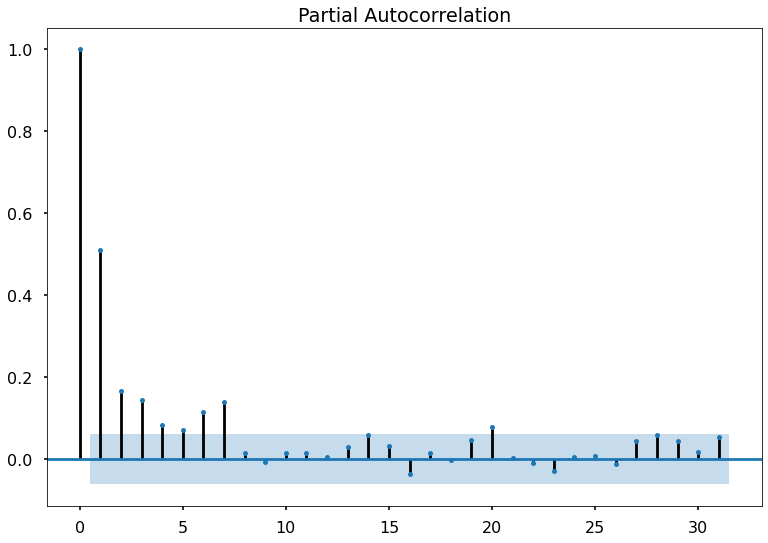

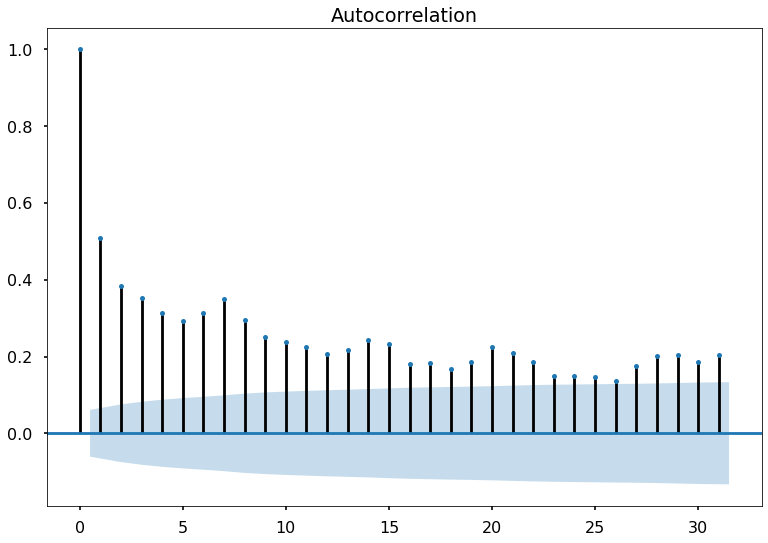

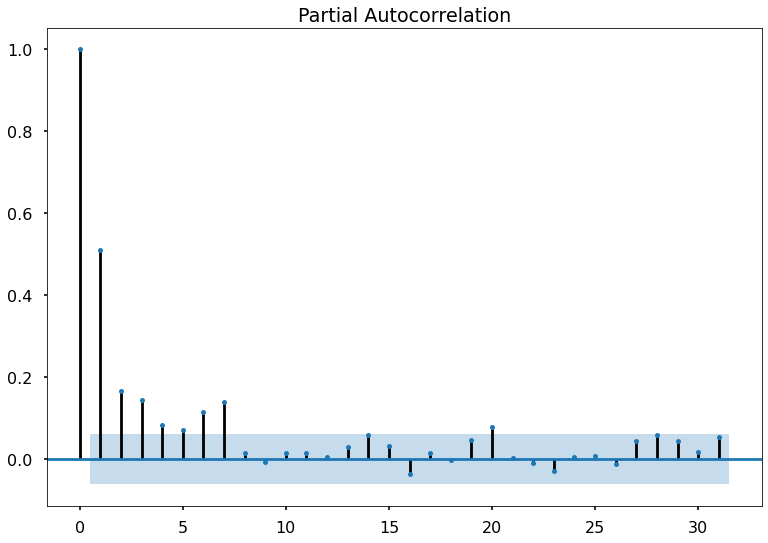

In [50]:
#plot autocorrelation and partial autocorrelation
#autocorrelation is a measure of the correlation between the lagged values of a time series
#partial autocorrelation is the correlation that results after removing the effect of any correlations due to the terms at shorter lags
plot_acf(all_data_by_day['total_sales'])
plot_pacf(all_data_by_day['total_sales'])

### 2.2 Rolling Window Features <a class="anchor" id="section_2_2"></a>

Rolling window feature is to calculate statistical value base on past values. In this example, we are using the statistical of 7 days (1 week) to work on the rolling window. 

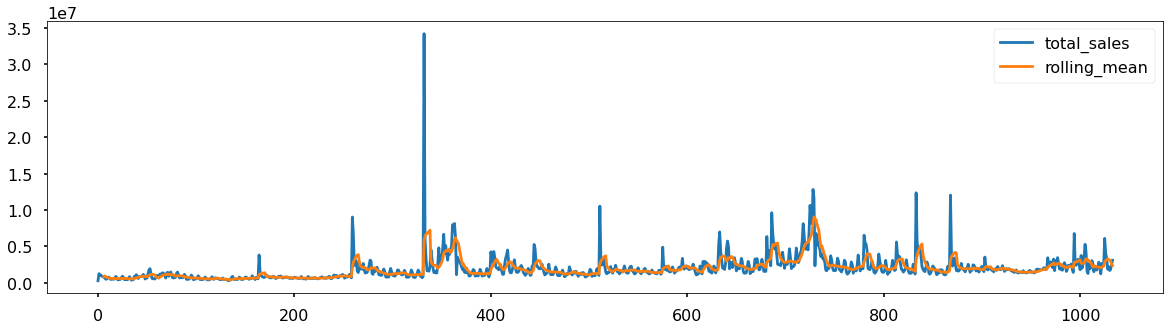

In [51]:
#construct the rolling mean of 7 days (1 week) compare with total sales
all_data_by_day['rolling_mean'] = all_data_by_day['total_sales'].rolling(window=7).mean()
all_data_by_day[['total_sales', 'rolling_mean']].plot(figsize=(20, 5))

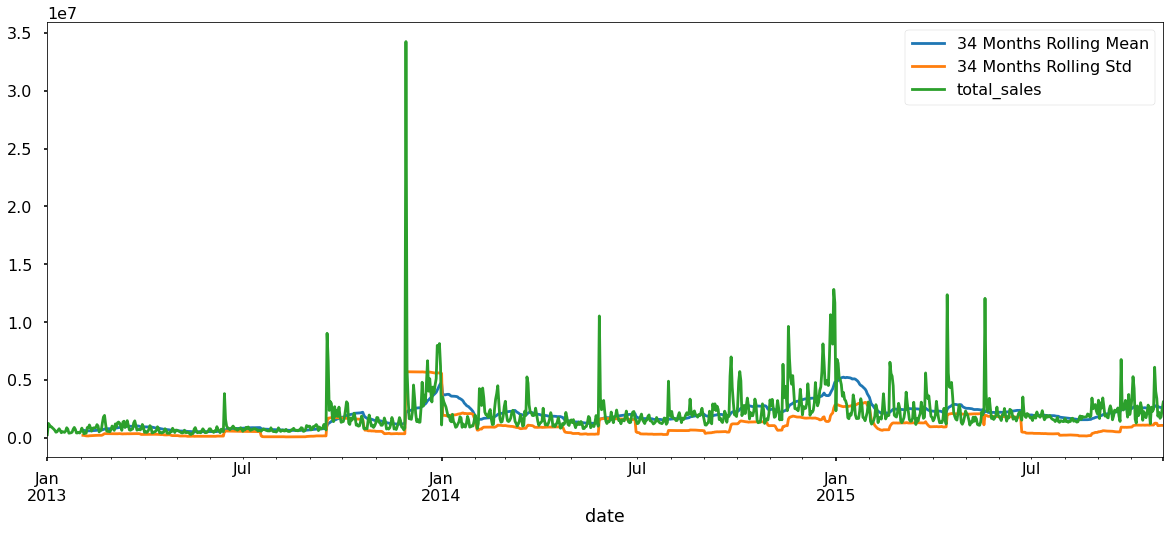

In [54]:
#construct the rolling mean and standard deviation of months compare with total sales
plt.rcParams['figure.figsize']=(20, 8)
all_data_by_day = all_data.groupby(['date']).agg(aggregations)
timeseries = all_data_by_day['total_sales']
timeseries.rolling(34).mean().plot(label='34 Months Rolling Mean')
timeseries.rolling(34).std().plot(label='34 Months Rolling Std')
timeseries.plot()
plt.legend()

### 2.3 Expanding Window Features <a class="anchor" id="section_2_3"></a>
Expanding window feature is to take all the most recent values to calculate the mean. 7 days of mean is used in this calculation. 

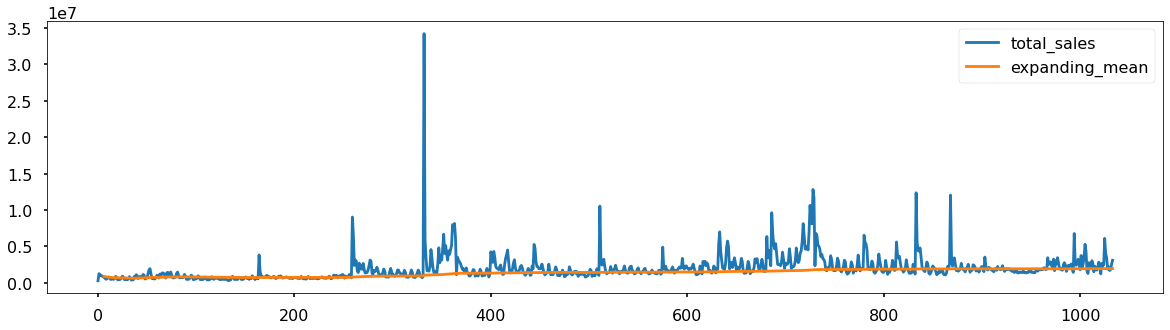

In [53]:
#construct the expanding mean of 7 days (1 week) compare with total sales
all_data_by_day['expanding_mean'] = all_data_by_day['total_sales'].expanding(7).mean()
all_data_by_day[['total_sales', 'expanding_mean']].plot(figsize=(20, 5))

## 3. Feature Selection <a class="anchor" id="section_3"></a>

## 4. Forecast Model <a class="anchor" id="section_4"></a>

### 4.1 Preparation for model predicting <a class="anchor" id="section_4_1"></a>

In [3]:
all_data_by_day = train
all_data_by_day['date'] = pd.to_datetime(all_data_by_day['date'])
all_data_by_day = all_data_by_day.set_index('date')
all_data_by_day = all_data_by_day['2013-01-01':'2015-10-31'].resample('D').sum()
all_data_by_day

,Unnamed: 0,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,Required,date_month,date_year,total_sales
date,,,,,,,,,,,
2013-01-01,4761583,0,11703,3506646,2.401346e+05,448.0,14948,355.0,355,714615,286395.59
2013-01-02,16588954,0,42896,12593934,1.002013e+06,1788.0,55024,1359.0,1359,2735667,1258654.76
2013-01-03,15443625,0,38137,11743441,8.866805e+05,1622.0,52795,1268.0,1268,2552484,1131019.36
2013-01-04,13838761,0,34187,10155776,7.941401e+05,1390.0,45953,1125.0,1125,2264625,965669.29
2013-01-05,14059543,0,33890,10474918,7.949034e+05,1373.0,46563,1131.0,1131,2276703,955022.60
...,...,...,...,...,...,...,...,...,...,...,...
2015-10-27,1807072267,42108,41437,13307202,1.813260e+06,1474.0,52859,1276.0,12760,2571140,2211635.13
2015-10-28,1682944824,39204,37110,12298356,1.537788e+06,3555.0,49449,1188.0,11880,2393820,1696390.10
2015-10-29,1913242703,44517,42604,14158867,1.643146e+06,1535.0,56456,1349.0,13490,2718235,1822707.40


In [4]:
y_to_train = all_data_by_day[:'2015-05-31'] # dataset to train
y_to_val = all_data_by_day['2015-06-01':] # last X months for test  
predict_date = len(all_data_by_day) - len(all_data_by_day[:'2015-06-01']) # the number of data points for the test set


In [5]:
#train = pd.read_csv(r'C:/Testing/DA/predictFutureSalesClean.csv')

In [6]:
# Only keep date & item_cnt_day
Forecast_IP = train[['date','item_cnt_day']]
Forecast_IP['date'] = pd.to_datetime(Forecast_IP['date'])
# Set date as index
Forecast_IP = Forecast_IP.set_index('date')
## Select time period for weekly aggregation
Forecast_IP_weekly = Forecast_IP['2013-01-01':'2015-10-31'].resample('W').sum()
Forecast_IP_weekly

<ipython-input-6-5835c219f514>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Forecast_IP['date'] = pd.to_datetime(Forecast_IP['date'])


,item_cnt_day
date,
2013-01-06,7891.0
2013-01-13,6505.0
2013-01-20,5755.0
2013-01-27,6125.0
2013-02-03,5551.0
...,...
2015-10-04,17857.0
2015-10-11,12808.0
2015-10-18,14922.0


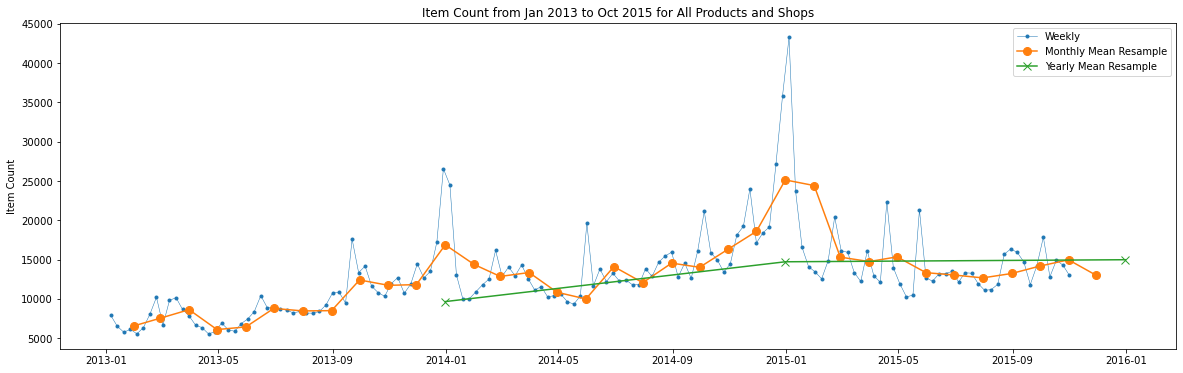

In [7]:
y = Forecast_IP_weekly['item_cnt_day']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.plot(y.resample('Y').mean(),marker='x', markersize=8, linestyle='-', label='Yearly Mean Resample')
ax.set_ylabel('Item Count')
ax.set_title('Item Count from Jan 2013 to Oct 2015 for All Products and Shops')
ax.legend();

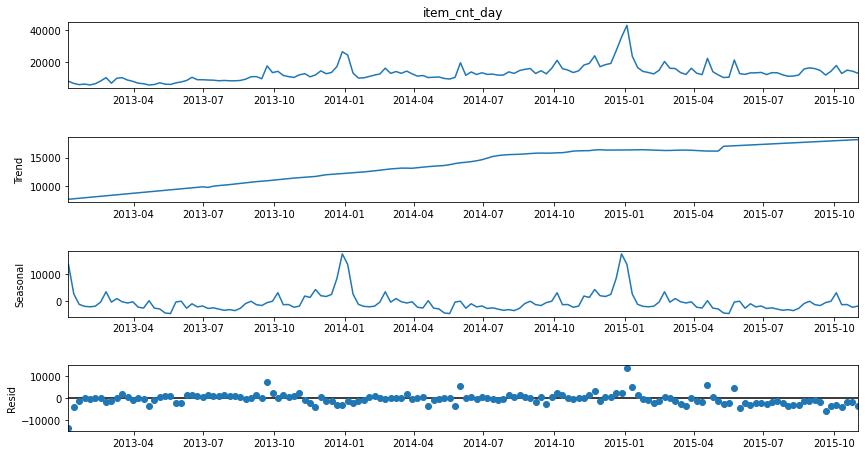

In [8]:
# graphs to show seasonal_decompose
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

seasonal_decompose(y)

In [9]:
normData_filtered = train[['date','item_cnt_day','item_category_id']]

In [10]:

#create unique list of names
UniqueNames = normData_filtered.item_category_id.unique()

#create a data frame dictionary to store your data frames
df = {elem : pd.DataFrame for elem in UniqueNames}

for key in df.keys():
    df[key] = normData_filtered[:][normData_filtered.item_category_id == key]

In [11]:
count=0
for elem in df:
    count+=1
print('Total Item Category is {}'.format(count))

Total Item Category is 60


In [12]:
# Only keep date & item_cnt_day
Forecast_IP_item20 = df[20][['date','item_cnt_day']]
Forecast_IP_item20['date'] = pd.to_datetime(Forecast_IP_item20['date'])
# Set date as index
Forecast_IP_item20 = Forecast_IP_item20.set_index('date')
## Select time period for weekly aggregation
Forecast_IP_item20_weekly = Forecast_IP_item20['2013-01-01':'2015-10-31'].resample('W').sum()
Forecast_IP_item20_weekly

<ipython-input-12-82b882e204ad>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Forecast_IP_item20['date'] = pd.to_datetime(Forecast_IP_item20['date'])


,item_cnt_day
date,
2013-11-24,65.0
2013-12-01,1680.0
2013-12-08,725.0
2013-12-15,453.0
2013-12-22,792.0
...,...
2015-10-04,941.0
2015-10-11,1233.0
2015-10-18,1436.0


In [13]:
## Validate the start date of item category 20
df_validate = train.loc[train['item_category_id']==20]
df_validate= df_validate.sort_values(by='date')

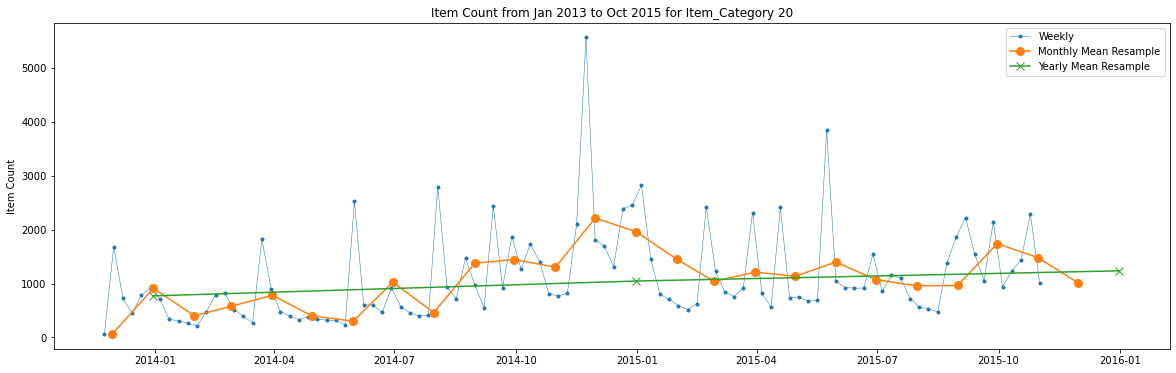

In [14]:
y = Forecast_IP_item20_weekly['item_cnt_day']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.plot(y.resample('Y').mean(),marker='x', markersize=8, linestyle='-', label='Yearly Mean Resample')
ax.set_ylabel('Item Count')
ax.set_title('Item Count from Jan 2013 to Oct 2015 for Item_Category 20')
ax.legend();

In [15]:
# graphs to show seasonal_decompose
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y,model='additive', freq=30)
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

In [16]:
# Check the date at 70% of the dataset
Forecast_IP_item20_weekly.iloc[int(len(y)*0.7)]

item_cnt_day    820.0
Name: 2015-04-05 00:00:00, dtype: float64

In [17]:
y_to_train = y[:'2015-04-05'] # dataset to train
y_to_val = y['2015-04-06':] # last X months for test  
predict_date = (len(y) - len(y[:'2015-04-06'])) # the number of data points for the test set

In [18]:
predict_date

30

### 4.2 Holt’s Linear Trend Method <a class="anchor" id="section_4_2"></a>

Holt method helps to forecast time series data that has a trend by expanding the SES method. SES method introduces level smooting parameter (α) and Holt methods introduces trend smoothing parameter (β*). 
Both parameters (α and β*) are in the range between 0 to 1. 

There are 2 Holt's model. 
1. Holt's additive model
2. Exponential model

Exponential model is not discussed in here as it is more appropriate for situations where the increase or decrease starts slowly at the beginning and then accelrates rapidly later. 


In [19]:




def holt(y, y_to_train,y_to_test,smoothing_level, smoothing_slope, predict_date):
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    fit1 = Holt(y_to_train).fit(smoothing_level, smoothing_slope,optimized=False)
    fcast1 = fit1.forecast(predict_date).rename("Holt's Liner Trend")
    # specific smoothing level
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of Holt''s Linear trend {}'.format(round(np.sqrt(mse1), 2)))
    
    fit1.fittedvalues.plot(marker="o", color='blue')
    fcast1.plot(color='blue', marker="o", legend=True)
    
    plt.show()



The Root Mean Squared Error of Holts Linear trend 723.94


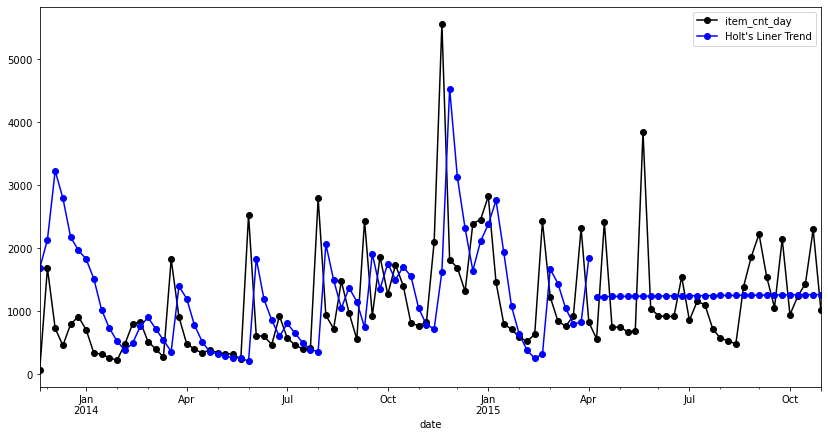

In [20]:
plt.figure()
holt(y, y_to_train, y_to_val, 0.6, 0.2, predict_date)

### 4.3 Holt-Winters’ Seasonal Method <a class="anchor" id="section_4_3"></a>

The Holt-Winters model extends from Holt Linear method to allow the forecasting of time series data that has both trend and seasonaility. This method introduces seasonality smoothing parameter: γ

There are 2 types of seasonality
1. Additive - Seasonal changes in the data stay roughly the same over time and don't fluctuate in relation to the overall data
2. Multiplicative - Seasonal variation changes in relation to the overal changes in the data. Thus, if the data is trending upward, the seasonal differences grow proportionally as well. 

As the seasonality of our data is additive, thus, we will only discuss additive seasonality here. 

In [21]:


def holt_win_sea(y,y_to_train,y_to_test,seasonal_type,seasonal_period,predict_date):
    
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    if seasonal_type == 'additive':
        fit1 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add').fit(use_boxcox=True)
        fcast1 = fit1.forecast(predict_date).rename('Additive')
        mse1 = ((fcast1 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse1), 2)))
        
        fit2 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
        fcast2 = fit2.forecast(predict_date).rename('Additive+damped')
        mse2 = ((fcast2 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse2), 2)))
        
        fit1.fittedvalues.plot(style='--', color='red')
        fcast1.plot(style='--', marker='o', color='red', legend=True)
        fit2.fittedvalues.plot(style='--', color='green')
        fcast2.plot(style='--', marker='o', color='green', legend=True)
    
    elif seasonal_type == 'multiplicative':  
        fit3 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul').fit(use_boxcox=True)
        fcast3 = fit3.forecast(predict_date).rename('Multiplicative')
        mse3 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse3), 2)))
        
        fit4 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)
        fcast4 = fit4.forecast(predict_date).rename('Multiplicative+damped')
        mse4 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse4), 2)))
        
        fit3.fittedvalues.plot(style='--', color='red')
        fcast3.plot(style='--', marker='o', color='red', legend=True)
        fit4.fittedvalues.plot(style='--', color='green')
        fcast4.plot(style='--', marker='o', color='green', legend=True)
        
    else:
        print('Wrong Seasonal Type. Please choose between additive and multiplicative')

    plt.show()
        
        


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


The Root Mean Squared Error of additive trend, additive seasonal of period season_length=20 and a Box-Cox transformation 1013.12
The Root Mean Squared Error of additive damped trend, additive seasonal of period season_length=20 and a Box-Cox transformation 819.34


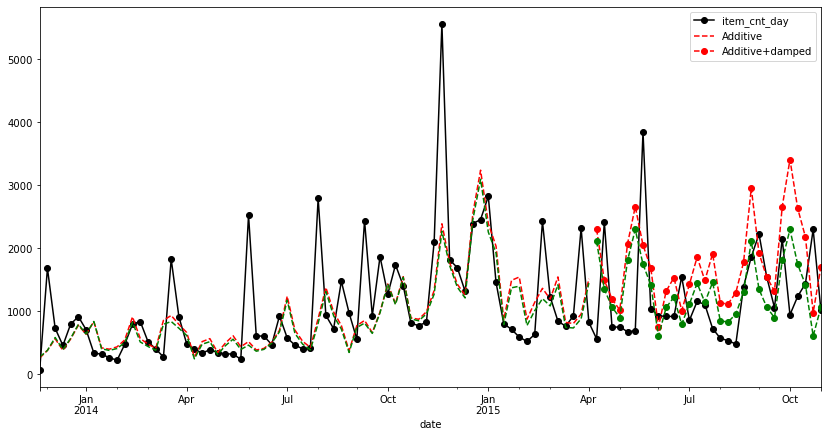

In [22]:
holt_win_sea(y, y_to_train,y_to_val,'additive',20, predict_date)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1071289                alpha                 True
smoothing_slope               2.762e-35                 beta                 True
smoothing_seasonal           1.7363e-20                gamma                 True
initial_level                 1018.3605                  l.0                 True
initial_slope                 8.3570866                  b.0                 True
initial_seasons.0            -492.86225                  s.0                 True
initial_seasons.1            -446.93824                  s.1                 True
initial_seasons.2            -793.44730                  s.2                 True
initial_seasons.3            -390.42197                  s.3                 True
initial_seasons.4            -180.47744                  s.4                 True
initial_seasons.

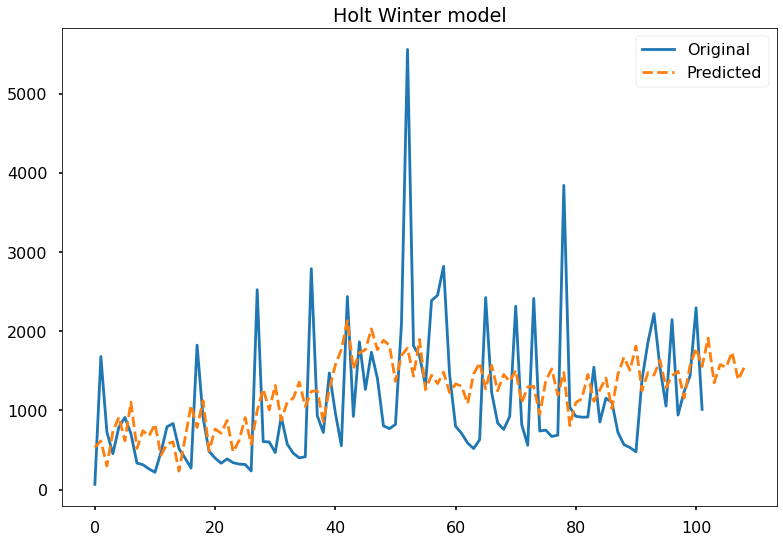

In [23]:
# Holt-Winters’ Seasonal Method  
model = HWES(y, seasonal_periods=12, trend='add', seasonal='add')
model_fit = model.fit()
print(model_fit.summary().tables[1])

# make prediction
yhat = model_fit.predict(12, len(y)+18) # predict N ahead of the last one

dataList = list(y)
yhatList = list(yhat)

plt.style.use('seaborn-poster')
plt.figure()
plt.plot(dataList, label='Original')
plt.plot(yhatList, ls='--', label='Predicted')
plt.legend(loc='best')
plt.title('Holt Winter model')
plt.show()


In [24]:
# Evaluation Score

rmse = sqrt(mean_squared_error(dataList,yhatList[0:102]))
print('Holt Winter RMSE: %.1f' % rmse)

mae = mean_absolute_error(dataList,yhatList[0:102])
print('Holt Winter MAE: %.1f' % mae)


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(dataList,yhatList[0:102])
print('Holt Winter MAPE: %.1f' % mape)

Holt Winter RMSE: 767.5
Holt Winter MAE: 576.2
Holt Winter MAPE: 78.1


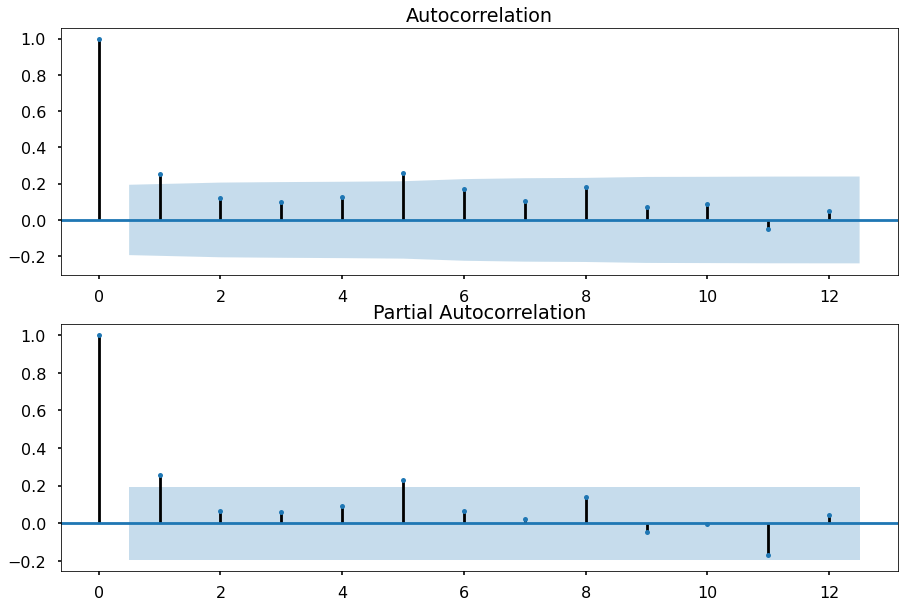

In [25]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
# Get p and q for Holt Winter

plt.figure(figsize=(15,10))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(y, lags=12, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(y, lags=12, ax=ax)
#plt.tight_layout()
plt.show()